# Ch3.Graphical Causal Models

3장에서는 1장에서 배운 식별과 추정에서 **식별** 부분을 더 자세히 다룬다. 또한 데이터로 매개변수를 추정하지 않고 그래프 모델(graphical model)을 다루며 대부분 이론적인 내용이다. 식별은 인과추론의 핵심이므로 식별 이론 학습은 실생활에서 인과적 문제를 해결하는 데 기본이 된다. 이번 장에서는 다음과 같은 내용을 다룬다.  
- 그래프 모델을 소개하면서 그래프 인과모델과 그래프에서 연관성이 어떻게 흐르는지, 기존 라이브러리를 사용하여 그래프를 쿼리(query)하는 법을 배운다.  
- 그래프 모델을 통해서 식별의 개념을 재해석한다.  
- 흔히 식별을 방해하는 편향의 원인 두 가지와 인과 그래프 구조를 바탕으로 할 수 있는 일을 알아본다.

---

## 3.1 인과관계와 그래프

잘 표현된 언어는 명확하게 생각하도록 만든다. 곧 배울 그래프 모델은 인과관계의 기본 언어 중 하나라고 볼 수 있다. 그래프 모델은 인과추론 문제를 **구조화**하며, 식별 가정을 명확하게 시각적으로 표현하는 강력한 방법이다. 즉 **그래프 모델은 생각을 명확하게 표현하도록 도와준다.**

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● 구조적 인과모델</strong><br>
    일부 과학자들은 인과추론의 통일된 언어를 지칭하는데 구조적 인과모델(Structural Causal Model,SCM)이라는 용어를 사용한다. 이 모델은 그래프와 인과 방정식(Causal equation)으로 구성된다. 이번 장에서는 주로 SCM의 그래프 측면에 초점을 맞춰 설명한다.
</div>

예시로, 교차 판매 이메일이 전환에 미치는 영향을 추정한 사례를 다시 살펴본다. 여기서 처치 $T$는 교차 판매 이메일이고 결과 $Y$는 고객이 신규 제품으로의 전환 여부를 나타낸다.

In [1]:
import numpy as np
import pandas as pd

url= "https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/cross_sell_email.csv"

data=pd.read_csv(url)
data

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0
...,...,...,...,...
318,0,long,18,0
319,1,no_email,16,0
320,0,no_email,15,0
321,1,no_email,16,0


해당 사례에서, $T$는 무작위로 배정되었다. 따라서 처치는 잠재적 결과와 독립이라고 ($(Y_0,Y_1) \bot T$) 볼 수 있으며, 상관관계를 인과관계로 만든다.
$$
E[Y_1-Y_0] = E[Y\ |\ T=1]-E[Y\ |\ T=0]
$$
중요한 것은 단지 데이터만 보고 독립성 가정이 성립한다고 애기할 수는 없다는 점이다. 앞서 논의했듯이, 실험 대상에게 처치 배정에 관한 매커니즘 정보가 있어야 독립성 가정이 유지된다고 할 수 있다. 여기서는 무작위로 고객에게 이메일이 발송되었음을 알기 때문에 독립성 가정이 성립한다고 볼 수 있다.

### 인과관계 시각화

교차 판매 이메일이 전환을 유도하고 관측된 다른 변수인 나이와 성별도 전환의 원인이 된다고 생각해보자. 또한 관측되지 않은 변수는 $U$로 표시한다. 예를 들어, 고객 소득, 사회적 배경, 나이(회사가 서비스하는 도시에서 제품이 다양한 인구 집단에 어떻게 어필되는지에 관한 정보)와 같이 전환을 유도하는 관측되지 않은 변수가 많을 것이다. 해당 변수들은 측정하지 않을 것이므로, 측정되지 않은 모든 변수를 나타내는 $U$ 노드(node)에 묶어서 표현한다. 마지막으로 $T$(처치)를 가리키는 랜덤화 노드를 추가하여 교차 판매 이메일이 무작위로 발생되었다는 구조를 나타낼 수 있다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● DAG</strong><br>
    인과 그래프를 DAG라고 부르기도 한다. DAG는 <b>유향 비순환 그래프</b>(directed acyclic graph)의 약자이다. 방향이 있는 부분은 없는 부분과 달리, SNS처럼 엣지(edge)에 방향성을 나타낸다. 비순환 부분은 그래프에 루프나 순환(cycle)이 없음을 나타낸다. 인과관계에는 되돌릴 수 없는 비가역적(non-invertible) 가정이 있으므로 인과 그래프는 일반적으로 방향성있는 비순환 그래프이다.
</div>

다음과 같이 그래프 시각화 라이브러리 `graphviz`를 사용해서 그래프를 활용해 시각화할 수 있다.

In [2]:
import graphviz as gr

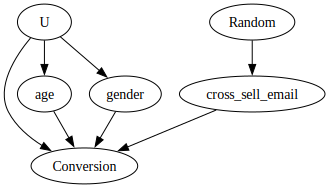

In [3]:
g_cross_sell = gr.Digraph()

g_cross_sell.edge('U','Conversion')
g_cross_sell.edge('U','age')
g_cross_sell.edge('U','gender')

g_cross_sell.edge('Random','cross_sell_email')
g_cross_sell.edge('cross_sell_email','Conversion')
g_cross_sell.edge('age','Conversion')
g_cross_sell.edge('gender','Conversion')

g_cross_sell

그래프의 각 노드는 **확률변수(Random Variable,RV)** 이다. 화살표나 엣지를 사용하여 한 변수가 다른 변수의 원인이 되는지 표시할 수 있다. 이 그래프 모델에서는 전환의 원인은 이메일이 되고, $U$가 나이,전환,성별 등 변수의 원임임을 나타낸다. 이 그래프 모델 언어는 세상이 어떻게 작동하는지에 관한 믿음을 명확하게 반영하므로 인과관계에 대한 생각을 표현하는 데 도움이 된다. 그런데 오늘날 데이터 적용 사례에 일반적으로 존재하는 수백 개의 변수를 모두 그래프에 표현할 방법은 없다. 따라서 이 부분이 얼마나 비현실적인지 고민할 필요가 없다. 실제로 전달하려는 일반적인 인과 구조를 유지하면서 노드를 묶어 획기적으로 그래프를 단순화할 수 있다.  
예를 들어, 앞의 그래프를 가지고 관측 가능한 변수를 $X$ 노드로 묶을 수 있다. 두 변수 $U$에 의해 발생하고 전환의 원인이 되므로 이들을 결합해도 인과 구조는 그대로 유지된다.  
또한 무작위로 배정되거나 개입된 변수를 표현할 때는 들어오는 화살표를 모두 제거하면 된다.

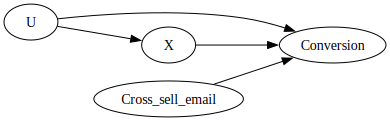

In [4]:
# rankdir : LR인 경우, 그래프가 왼쪽에서 오른쪽으로 화살표가 향하도록 설정
g_cross_sell = gr.Digraph(graph_attr={'rankdir':"LR"})

g_cross_sell.edge('U','Conversion')
g_cross_sell.edge('U','X')

g_cross_sell.edge('Cross_sell_email','Conversion')
g_cross_sell.edge('X','Conversion')

g_cross_sell

여기서 흥미로운 점은 DAG에서 가장 중요한 정보는 **그래프 안에서 누락될 수도 사실**이다. 즉, 한 변수에 다른 변수로 연결되는 엣지가 없다는 것은 두 변수 사이에 직접적인 인과관계가 없다고 가정한다는 의미이다. 예를 들어, 앞의 그래프에서는 처치와 결과, 두 노드 **모두**에게 영향을 주는 원인이 없다고 가정한다.

이 부분을 읽으면서 내용이 완전히 이치에 맞지 않는다고 생각할 수 있으며, 이해가 안되는 것이 지극히 정상이다. 하지만 지금은 그래프가 상관관계는 인과관계가 아닌 이유를 이해하는 데 매우 강력한 도구임을 기억하자.

### 컨설턴트 영입 여부 결정하기

처치가 랜덤화되지 않은 예제를 살펴보며 DAG의 유용함을 알아본다. 만약 여러분이 최고 수준의 컨설턴트 영입 여부를 고려하는 회사의 관리자라고 생각해보자. 컨설턴트의 몸값이 비싸다는 것을 알지만, 그들이 업계 최고의 회사와 함께 일하며 쌓은 전문 지식을 보유했다는 것도 안다. 수익성이 매우 좋은 회사만 최고 수준의 컨설턴트를 고용할 수 있기 때문에 그러한 컨설턴트를 고용했을 때 비즈니스를 개선할 수 있는지, 그들의 존재가 좋은 회사의 실적(수익으로 측정)과 상관관계가 있는 건지 확신할 수 없다. 회사마다 컨설턴트를 무작위로 배정받을 수 있다면 최고 수준의 컨설턴트 고용이 얼마나 효과적인지 쉽게 답할 수 있지만, 현실적으로 어렵기에 다른 방법을 생각해 내야 한다. 이는 상관관계로부터 인과관계를 풀어야 하는 문제이다. 인과관계 메커니즘에 관한 생각을 다음과 같이 그래프로 표현해서 이를 이해할 수 있다.

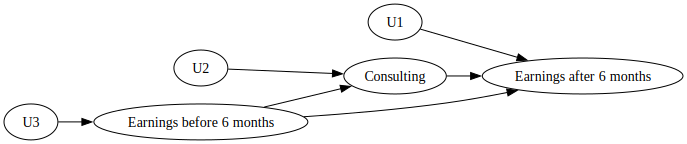

In [5]:
g_consulting = gr.Digraph(graph_attr={'rankdir':'LR'})

g_consulting.edge('U1','Earnings after 6 months')
g_consulting.edge('U2','Consulting')
g_consulting.edge('U3','Earnings before 6 months')

g_consulting.edge('Consulting','Earnings after 6 months')
g_consulting.edge('Earnings before 6 months','Consulting')
g_consulting.edge('Earnings before 6 months','Earnings after 6 months')

g_consulting

측정할 수 없는 다른 요소가 변수의 원인이라는 사실을 나타내려고 각 변수에 $U$ 노드를 추가한 부분을 보자. 그래프는 일반적으로 확률변수를 나타내므로 임의의 $U$가 모든 변수의 원인이 될 것으로 예상할 수 있다. 그러나 이러한 요소는 인과 구조에 영향을 주지 않을 것이므로 생략하는 편이 좋다.

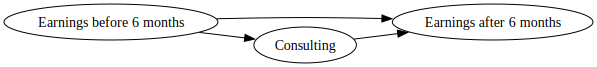

In [35]:
g_consulting = gr.Digraph(graph_attr={'rankdir':'LR'})

g_consulting.edge('Earnings before 6 months','Earnings after 6 months')
g_consulting.edge('Earnings before 6 months','Consulting')
g_consulting.edge('Consulting','Earnings after 6 months')

g_consulting

이 사례에서 회사의 과거 실적이 최고 수준이 컨설턴트를 고용하게 한다고 애기한다. 회사가 잘 된다면 비싼 서비스 비용을 지불할 수 있지만, 실적이 좋지 않다면 지불할 여유가 없다. 따라서 과거 실적이 컨설턴트를 고용할 확률을 결정한다. 이 관계가 반드시 결정적(Deterministic)이지 않다는 점을 기억하자. 단지 **실적이 좋은 회사가 최고 수준의 컨설턴트를 고용할 가능성이 더 높다는 의미**이다.

그뿐만 아니라 지난 6개월 동안 잘된 회사는 이후 6개월 동안에도 잘될 가능성이 매우 높다. 물론 항상 그렇지는 않지만, 평균적으로 그렇기 때문에 과거 실적에서 미래 실적까지의 엣지를 추가했다. 마지막으로 컨설팅으로부터 회사의 미래 실적에 관한 엣지를 추가했다. 목표는 이러한 그래프 연결의 강점을 파악하는 것이며, 이 연결이 우리가 관심 있는 인과관계이다.

컨설팅이 실제로 회사의 실적을 높이는지에 대한 답을 하기는 간단하지 않다. 컨설팅과 미래 실적 사이의 연관성에는 두 가지 원인이 있다. 하나는 인과관계이지만 다른 하나는 인과관계가 아니다. 이를 이해하고 구분하려면 먼저 인과 그래프에서 연관성이 어떻게 흐르는지 간단히 살펴봐야 한다.

---

## 3.2 그래프 모델의 구조

그래프 모델을 보통 대학교에서 한 학기 내내 수업을 한다. 하지만 여기선 **그래프 모델에 어떤 독립성 및 조건부 독립성 가정이 수반되는지 이해하는 것**이 중요하다. 연관성은 개울에 물 흐르듯이 그래프 모델을 따라 흐른다. 그래프에서 어떻게 변수를 다루는지에 따라 이 흐름을 막거나 활성화할 수 있다. 다음 세 가지 그래프 구조와 예시를 보면서 이를 이해해본다. 그래프 모델에서 상관관계, 독립성 및 조건부 독립성의 흐름에 관한 모든 내용을 파악할 수 있다.

### 사슬 구조 (Chain)

첫 번째로 간단한 그래프인 사슬(chain)구조를 살펴본다. 여기서 $T$는 $M$의 원인이 되고, $M$은 $Y$의 원인이 된다. 중간 노드(intermediary node)는 $T$와 $Y$ 사이의 관계를 매개하는 역할이므로 매개자(mediator)라고 한다.

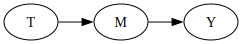

In [7]:
g_chain = gr.Digraph(graph_attr={'rankdir':'LR'})

g_chain.edge('T','M')
g_chain.edge('M','Y')

g_chain

이 그래프에서 **인과관계는 화살표 방향으로 흐르지만, 상관관계는 쌍방으로 흐른다.** 구체적인 예시를 통해 이해해보자. 인과추론을 알게 되면($T$) 문제 해결력이 향상되고($M$), 문제 해결력을 향상시키면 승진할 가능성($Y$)이 높아진다고 해보자. 따라서 인과적 지식은 문제 해결력을 향상시키고, 이는 결국 승진의 원인이 된다. 여기서 승진은 인과추론 지식에 달려 있다고 말할 수 있고, 인과추론 전문성이 높을수록 승진할 가능성이 높아진다. 또한 승진 가능성이 높을수록 인과추론 지식이 많을 확률도 높아진다.  
즉, 비록 인과관계가 한 방향으로만 존재하더라도 **승진이 인과추론 지식과 연관되는것과 마찬가지로 인과추론 지식도 승진과 연관된다.** 이렇게 두 변수가 서로 연관되면 '두 변수는 독립이 아니다'($T\not\perp Y$)라고 한다.

이제 매개자 $M$을 **고정**해본다. 이 예제에서는 $M$이 동일한 사람, 즉 예시에서 문제 해결력이 동일한 사람만 살펴본다. 이를 공식적으로는 $M$에 대한 조건부라고 한다. 이 경우 **종속성(dependency)이 차단(block)** 된다. 그래서 $M$이 주어졌을 때 $T$와 $Y$는 독립이다. 이를 수학적으로 다음과 같이 쓸 수 있다.
$$
T \bot Y \ |\ M
$$

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● 변수 고정</strong><br>
    그래프에서 변수를 고정하는 것은 특정 변수의 값을 일정하게 유지하면서 다른 변수들 간의 관계를 관측하는 것을 의미한다. 이 과정을 통해 해당 고정 변수의 영향을 통제하고, 다른 변수들 사이의 관계를 더 명확하게 이해할 수 있다. 고정하는 과정을 종종 <b>조건부로 설정</b>한다고 한다.
</div>

노드가 조건부로 주어진 경우는 다음과 같이 음영 처리한다.

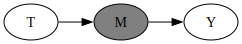

In [8]:
g_chain = gr.Digraph(graph_attr={'rankdir':'LR'})

g_chain.edge('T','M')
g_chain.edge('M','Y')

g_chain.node('M',style='filled',fillcolor = 'grey')

g_chain

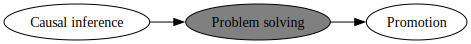

In [9]:
g_promotion =gr.Digraph(graph_attr={'rankdir':'LR'})

g_promotion.edge('Causal inference','Problem solving')
g_promotion.edge('Problem solving','Promotion')

g_promotion.node('Problem solving',style='filled',fillcolor='grey')

g_promotion

M에 대한 조건부란, 문제 해결력이 동일한 사람들을 살펴볼 때 어떤 사람이 인과추론에 능숙한지 아는 것만으로는 승진 가능성에 대한 추가 정보를 얻을 수 없다는 의미다. 수학적으로는 다음과 같다.
$$
E[Y\ |\ M,T] = E[Y\ |\ M]
$$
$$
E[Promotion\ |\ Problem\ solving\ ability,Causal\ inference\ ability ]\ = E[Promotion\ |\ Problem\ solving\ ability]
$$
그 반대도 마찬가지로, 어떤 사람의 문제 해결력을 알게 되면 직장 승진 상태를 알아도 인과추론 지식에 관한 추가 정보를 제공하지 않는다.

일반적으로, 앞서 그래프에서와 같은 사슬이 있을 때, 매개자 $M$을 조건부로 하면 $T$에서 $Y$로 흐르는 연관성은 차단된다.  
$$
T \not\perp Y
$$
하지만 $M$이 주어진 경우는 다음과 같다.
$$
T \perp Y\ |\ M
$$

### 분기 구조 (Fork)

다음으로 분기(fork) 구조를 살펴본다. 이 구조에는 **공통 원인**(common cause)이 존재한다. 같은 변수가 그래프 아래쪽 다른 변수의 원인이 된다. 분기 구조에서 연관성은 화살표의 반대 반향으로 흐른다.

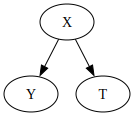

In [10]:
g_fork = gr.Digraph()

g_fork.edge('X','Y')
g_fork.edge('X','T')

g_fork

예를 들어, 통계학($X$) 덕분에 인과추론($Y$)과 머신러닝($T$)에 관해 더 많이 알게 되었다고 해보자. 하지만 인과추론을 잘 알아도 머신러닝에 큰 도움이 되지는 않으며, 그 반대도 마찬가지이므로 두 변수 사이에는 화살표가 없다.  
이 그래프는 인과추론이 머신러닝에 도움이 되지는 않지만, 누군가의 통계 지적수준을 모르더라도 인과추론을 잘 안다면 머신러닝도 능숙할 가능성이 높음을 알려준다. 만약 인과추론에 능숙하다면 통계를 잘 알 가능성이 높으므로 머신러닝도 잘 다룰 가능성이 높다.  
분기 끝에 있는 변수들은 서로의 원인이 아니지만, 같은 원인으로 발생하므로 함께 움직인다. 인과추론에서는 **처치와 결과 사이에 공통 원인이 있을 때, 그 공통 원인을 교란 변수(confounder)라고 한다.**

분기 구조는 인과추론에서 매우 중요하다. 다른 예시로 기술 채용 담당자들을 때때로 지원자들에게 이진 트리(binary tree)를 뒤집거나 파이썬에서 중복 요소를 세는 것과 같은 문제들을 해결하도록 요청한다. 채용 담당자들은 기본적으로 다음 그래프에서처럼 분기 구조를 통해 연관성이 흐른다는 사실을 활용한다.

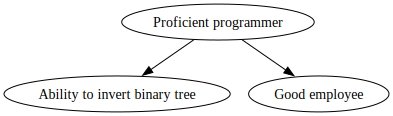

In [11]:
g_employment = gr.Digraph()

g_employment.edge('Proficient programmer','Ability to invert binary tree')
g_employment.edge('Proficient programmer','Good employee')

g_employment

채용 담당자는 능력있는 프로그래머가 좋은 성과를 낸다는 사실을 안다. 하지만 면접을 볼 때까지는 지원자가 좋은 프로그래머인지 알 수 없다. 그래서 채용 담당자는 지원자들이 좋은 프로그래머라면 답변할 수 있을 만한 질문을 한다. 이 질문은 지원자가 실무에서 마주칠 문제와 관련이 없어도 된다. **이는 단지 좋은 프로그래머인지 아닌지를 나타내는 신호일 뿐이다.** 이 질문에 답하는 지원자는 아마도 좋은 프로그래머일 것이고, 이는 곧 좋은 직원이 될 가능성이 높음을 의미한다.

이제 채용 담당자가 지원자가 이미 좋은 프로그래머임을 안다고 해보자. 지원자가 이전 회사에서 일할 때 만났던 사람이거나 경력이 훌륭할 수도 있다. 이 경우, 지원자가 면접 질문에 대답할 수 있는지가 좋은 직원이 될 것인지에 관한 추가 정보를 제공하지 않는다. 즉, **좋은 프로그래머라는 정보가 조건부로 주어졌다면 질문에 대답하는 것과 좋은 직원이 되는 것은 독립이다.**

일반적으로 분기 구조에서 공통 원인을 공유하는 두 변수는 종속이지만, 공통 원인이 주어지면 독립이다. $X$가 조건부로 주어지지 않는 경우, 다음과 같이 수식으로 표현할 수 있다.
$$
T \not\perp Y
$$
하지만 $X$가 주어진 경우는 다음과 같다.
$$
T \perp Y\ |\ X
$$

### 충돌부 구조 (Collider)

마지막으로 충돌부(collider) 구조를 살펴본다. 충돌부 구조는 두 노드가 하나의 자식(child)을 공유하지만, 그들 사이에 직접적인 관계가 없는 경우이다. 즉, 두 변수가 공통의 효과를 공유한다고 볼 수 있다. 이 공통 효과는 두 개의 화살표가 충돌하므로 **충돌부**라고 한다.

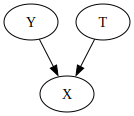

In [12]:
g_collider = gr.Digraph()

g_collider.edge('Y','X')
g_collider.edge('T','X')

g_collider

충돌부 구조에서 두 부모(Parent) 노드는 서로 독립이다. 하지만 공통 효과를 조건부로 두면 서로 종속관계가 된다. 예를 들어, 승진($X$)하는 방법에 통계학을 잘 알거나($Y$), 상사에게 잘 아부하는 것($T$) 두 가지 방법이 있다고 생각해보자. 승진을 조건부로 하지 않는다면(승진 여부를 모른다면) 통계 지식수준과 아부는 독립이다. 즉, 통계에 얼마나 능숙한지를 아는 것은 상사에게 얼마나 아부를 잘하는지에 관해서는 아무것도 말해주지 않는다. 반면, 승진했다면 갑자기 통계 지식수준이 상사에게 아부하는 수준에 관해 말해준다. 통계를 잘 알지 못해도 승진을 했다면 상사에게 아부를 잘할 가능성이 높다. 이와 반대로 통계를 잘 안다면 통계 수준이 이미 승진을 설명해주므로 아부를 잘하지 못할 가능성이 크다(물론 현실에서는 둘 다 잘할 수도 있다).  
이를 종종 **다른 요인에 의해 설명되는(explaining away) 현상**이라고도 한다.

일반적으로 충돌부에 조건부를 두면 연관 경로가 열리면서 부모 노드의 변수들은 종속관계가 생긴다. $X$를 조건부로 두지 않으면 경로가 닫힌 상태로 유지가 된다. 이를 다음과 같이 수식으로 표현할 수 있다.
$$
T \perp Y
$$
$X$가 주어진 경우는 다음과 같다.
$$
T \not\perp Y\ |\ X
$$

중요한 것은, 충돌부에 대한 조건부 대신 충돌부의 효과에 조건부를 두어도 동일한 종속 경로(dependence path)를 열 수 있다는 점이다. 이제 앞선 예제에서 승진이 연봉을 크게 올린다는 가정을 추가로 해보자. 이를 그래프로 다음과 같이 표현할 수 있다.

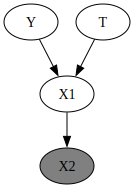

In [13]:
g_collider = gr.Digraph()

g_collider.edge('Y','X1')
g_collider.edge('T','X1')
g_collider.edge('X1','X2')

g_collider.node('X2',style='filled',fillcolor = 'grey')

g_collider

이 그래프에서 충돌부를 조건으로 두지 않고 해당 충돌부의 결과를 조건부로 해도, 충돌부 원인들은 종속이 된다. 즉, 승진 정보를 모르지만 거액 연봉 정보를 안다면, 통계 지식과 아부는 종속적인 관계가 된다.

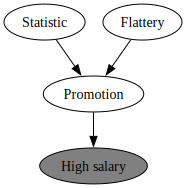

In [14]:
g_collider = gr.Digraph()

g_collider.edge('Statistic','Promotion')
g_collider.edge('Flattery','Promotion')
g_collider.edge('Promotion','High salary')

g_collider.node('High salary',style='filled',fillcolor = 'grey')

g_collider

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● 충돌부 구조의 명칭</strong><br>
    인과추론에서는 일반적으로 충돌부 구조를 영어로 collider 말고도 <b>Immorality</b>라고도 한다. 이는 부도덕성이라는 뜻을 가지며, 한 자식 노드가 서로 연관성이 없는 부모 노드를 갖는 구조이며 해당 구조가 마치 두 부모 노드 간에 '도덕적'인 관계가 결여된 것처럼 보인다는 점에서 유래되었다.
</div>

### 연관성 흐름 치트 시트

앞서 배웠듯이, 세 가지 구조(사슬, 분기, 충돌부)를 알면 독립성과 연관성에 대한 흐름의 더 일반적인 규칙을 그래프로 도출할 수 있다. 경로는 다음과 같은 필요충분조건에 따라 차단될 수 있다.  
1. 조건으로 주어진 비충돌부(non-collider) 구조가 포함됨  
2. 조건부오 주어지지 않고 자식(descendant)이 없는 충돌부가 포함됨

다음 그림은 어떻게 종속성(연관성)이 그래프에서 흐르는지 보여준다.

<center>

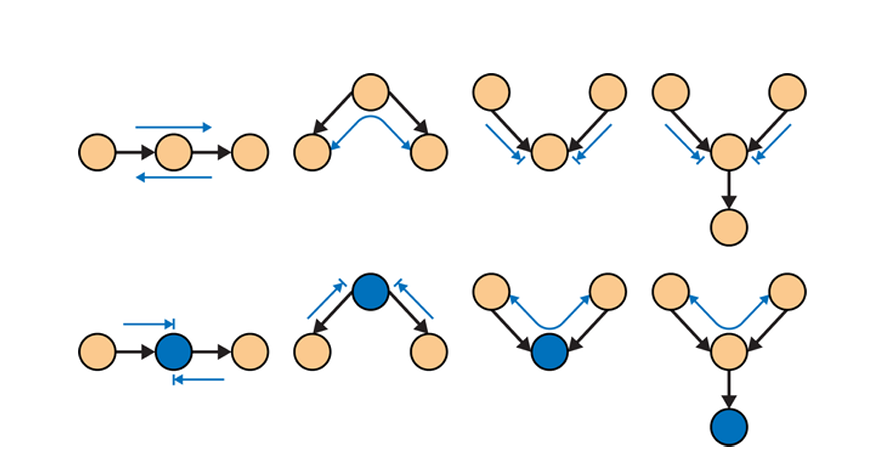

</center>

이러한 규칙이 잘 이해되지 않는다면, 기존 알고리즘을 활용해서 그래프 내 두 변수가 서로 종속인지 또는 독립인지 확인해볼 수 있다. 지금까지 배운 모든 내용을 종합한 마지막 예제를 살펴보고 어떻게 구현하는지 살펴본다.

### 파이썬에서 그래프 쿼리

다음 그래프를 보면서 방금 배운 개념을 체득하는 연습을 한다.

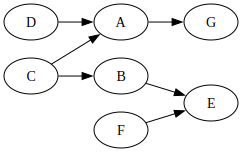

In [15]:
g_graph = gr.Digraph(graph_attr={'rankdir':'LR'})

g_graph.edge('D','A')
g_graph.edge('A','G')

g_graph.edge('C','A')
g_graph.edge('C','B')

g_graph.edge('B','E')
g_graph.edge('F','E')

g_graph

- 1. D와 C는 종속인가?  
- 2. A가 주어진 경우, D와 C는 종속인가?  
- 3. G가 주어진 경우, D와 C는 종속인가?  
- 4. D와 G는 종속인가?
- 5. A가 주어진 경우 D와 G는 종속인가?
- 6. A와 B는 종속인가?  
- 7. C가 주어진 경우, A와 B는 종속인가?  
- 8. G와 F는 종속인가?  
- 9. E가 주어진 경우, G와 F는 종속인가? 

그래프를 `networkx` 라이브러리의 `Digraph` 함수에 넣어서 정답을 확인할 수 있다. `networkx`는 그래프 모델을 다루는 라이브러리로, 그래프에 도움이 되는 여러 가지 유용한 알고리즘을 제공한다.

In [16]:
import networkx as nx

model = nx.DiGraph([
    ('C','A'),
    ('C','B'),
    ('D','A'),
    ('B','E'),
    ('F','E'),
    ('A','G'),
])

이제부터 위의 질문들에 대해 알아보자.

#### 1.D와 C는 종속인가?  
#### 2.A가 주어진 경우, D와 C는 종속인가?  
#### 3.G가 주어진 경우, D와 C는 종속인가?

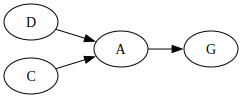

In [17]:
g_collider_ex = gr.Digraph(graph_attr={'rankdir':'LR'})

g_collider_ex.edge('D','A')
g_collider_ex.edge('C','A')

g_collider_ex.edge('A','G')

g_collider_ex

이들은 아까 살펴본 **충돌부 구조**를 형성하며, A가 충돌부이다. 충돌부 구조의 독립성 규칙에 따라 D와 C는 독립임을 알 수 있다. 또한 충돌부 A가 조건부로 주어졌다면 두 변수 사이에 연관성이 흐르기 시작한다는 것도 알 수 있다. `d_seperated` 메서드는 그래프에서 두 변수 간의 연관성 여부를 알려준다(d-seperation은 그래프에서 두 변수 간의 독립성을 표현하는 또 다른 용어이다). 변수를 조건부로 두려면 해당 변수를 관측된 집합에 추가하면 된다. 예를 들어, A가 주어졌을 때 D와 C가 종속인지 확인하려면 `d_seperated`에서 네 번째 인수에 `z={'A'}`를 전달한다.

In [18]:
print('Are D and C dependent?')
print(not(nx.d_separated(model,{'D'},{'C'},{})))

print('Are D and C dependent when A is given?')
print(not(nx.d_separated(model,{'D'},{'C'},{'A'})))

print('Are D and C dependent when G is given?')
print(not(nx.d_separated(model,{'D'},{'C'},{'G'})))


Are D and C dependent?
False
Are D and C dependent when A is given?
True
Are D and C dependent when G is given?
True


#### 4.D와 G는 종속인가?  
#### 5.A가 주어진 경우 D와 G는 종속인가?

변수 D,A,G가 **사슬 구조**를 형성하는 것을 주목하자. 연관성은 연쇄적으로 흐르므로 D는 G와 독립적이지 않다. 그러나 매개자 A를 조건으로 두면 연관성 경로는 차단된다.

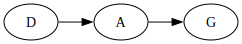

In [19]:
g_chain_ex = gr.Digraph(graph_attr={'rankdir':'LR'})

g_chain_ex.edge('D','A')
g_chain_ex.edge('A','G')

g_chain_ex

In [20]:
print('Are G and D dependent?')
print(not(nx.d_separated(model,{'G'},{'D'},{})))

print('Are G and D dependent when A is given?')
print(not(nx.d_separated(model,{'G'},{'D'},{'A'})))

Are G and D dependent?
True
Are G and D dependent when A is given?
False


#### 6.A와 B는 종속인가?  
#### 7.C가 주어진 경우, A와 B는 종속인가?

A,B,C는 **분기 구조**를 형성하며,C는 A와 B의 공통 원인이다. 분기를 통해 연관성이 흐름을 알기 때문에 A와 B는 독립이 아니다. 그러나 공통 원인을 조건으로 둔다면 연관성 경로는 차단된다.

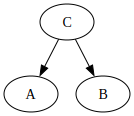

In [21]:
g_fork_ex = gr.Digraph()

g_fork_ex.edge('C','A')
g_fork_ex.edge('C','B')

g_fork_ex

In [22]:
print('Are A and B dependent?')
print(not(nx.d_separated(model,{'A'},{'B'},{})))

print('Are A and B dependent when C is given?')
print(not(nx.d_separated(model,{'A'},{'B'},{'C'})))

Are A and B dependent?
True
Are A and B dependent when C is given?
False


#### 8. G와 F는 종속인가?  
#### 9. E가 주어진 경우, G와 F는 종속인가? 

마지막으로 모든 것을 종합하여 G와 F에 대한 질문을 살펴본다. G부터 보면, G와 E는 C로부터 **분기하는 구조**이므로, 연관성이 흐르는 것을 알 수 있다. 그러나 연관성은 **충돌부** E에서 멈추며, 이는 G와 F가 독립임을 알 수 있다.

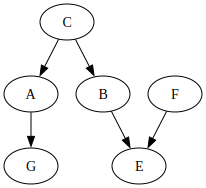

In [23]:
g_gf = gr.Digraph()

g_gf.edge('C','A')
g_gf.edge('C','B')

g_gf.edge('A','G')
g_gf.edge('B','E')

g_gf.edge('F','E')

g_gf

만약 E를 조건부로 두면 연관성이 충돌부로 흐르기 시작하고 경로가 열리면서 G와 F가 연결이 되어 종속관계가 생긴다.

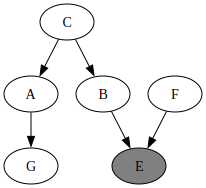

In [24]:
g_gf.node('E',style='filled',fillcolor='grey')

g_gf

세 가지 그래프 기본 구조와 함께 파이썬 라이브러리를 활용해서 그래프에서 독립성을 확인하는 방법을 배웠다. 이전의 컨설턴트 예제를 다시 생각해보자. 몸값이 비싼 최고의 컨설턴트를 고용하는 일이 회사 실적에 미치는 영향을 다음 그래프와 같이 이해하려고 했다.

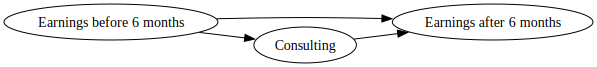

In [25]:
g_consulting

이 그래프에서 상관관계는 인과관계가 아닌 이유를 우리는 그래프 모델에서 배운 지식을 통해 확인할 수 있다. 이 그래프에는 **분기 구조**가 있다. 따라서 컨설팅과 기업의 미래 실적 사이에는 두 가지 흐름이 연관된다. 즉, 직접적인 인과 경로와 공통 원인 때문에 교란받는 **비인과 경로(Non-causal path)** 가 존재한다. 후자를 **뒷문 경로(backdoor path)** 라고 부른다. 이 그래프에서 교란을 주는 뒷문 경로가 있다는 사실은 컨설팅과 회사 실적 간의 관측된 상관관계를 인과관계만으로 설명할 수 없음을 보여준다.  
해당 예제에서 인과 경로는 컨설팅과 6개월 이후의 회사의 수익이며, 뒷문 경로는 이전 6개월 회사 수익이다.

그래프 내에서 연관성이 비인과 경로로 어떻게 흐르는지 이해하면 연관성과 인과성의 차이를 훨씬 더 정확하게 이해할 수 있다. 따라서 이제 그래프 모델이라는 새로운 관점에서 **식별**의 개념을 다시 살펴본다.

---

## 3.3 그래프 관점에서 식별 재해석

지금까지 무작위 배정이 없는 상황에서 인과관계를 찾기 어려운 이유는 실험군과 대조군을 서로 비교할 수 없어서라고 설명했다. 예를 들어, 고가의 컨설턴트를 고용하는 회사는 고용하지 않는 회사보다 일반적으로 과거 실적이 좋다. 이로써 앞서 보았듯이 편향이 발생한다.
$$
E[Y|T=1]-E[Y|T=0] = 
\underbrace{E[Y_1-Y_0|T=1]}_{\text{ATT}} + 
\underbrace{\{E[Y_0|T=1]-E[Y_0|T=0]\}}_{\text{Bias}}
$$

이제 인과 그래프를 배웠으므로 편향의 본질을 더 정확하게 파악할 수 있다. 중요한 점은 편향을 없애려면 무엇을 해야 하는지 이해할 수 있다는 것이다. 식별은 그래프 모델에서의 독립성과 밀접한 관련이 있다. 처치, 결과, 기타 관련 변수 간의 인과관계를 나타내는 그래프가 있는 경우, 식별은 해당 그래프에서 처치와 결과 간의 인과관계를 분리하는 과정이라고 볼 수 있다. 기본적으로 **식별 단계에서는 바람직하지 않은 모든 연관성을 차단한다.**

컨설팅 그래프를 살펴본다. 처치와 결과 사이에는 두 가지 연관성 경로가 있다.

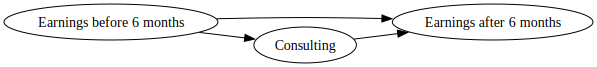

In [26]:
g_consulting

두 개의 연관성 경로가 있지만, 그 중 하나만 인과관계이다. 인과관계가 제거된 원래 그래프와 똑같은 인과 그래프를 만들어 편향을 확인할 수 있다. 이 그래프에서 처치와 결과가 여전히 연결된다면 비인과 경로 때문이며, 이는 편향이 있음을 나타낸다.

In [ ]:
consulting_model_severed = nx.DiGraph([
    ('Earnings before 6 months','Earnings after 6 months'),
    ('Earnings before 6 months','consulting'),
    ('consulting','Earnings after 6 months'), 
])

print(not(nx.d_separated(consulting_model_severed,{'consulting'},{'Earnings after 6 months'},{})))

True


이러한 비인과적 연결 흐름을 뒷문 경로라고 한다. $T$와 $Y$ 사이의 인과관계를 식별하려면 두 경로를 차단해 **인과 경로(Causal path)** 를 하나만 남겨야 한다. 컨설팅 예제에서, 공통 원인인 회사의 과거 실적을 조건으로 하면 해당 경로가 닫힘을 알 수 있다.

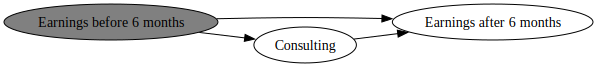

In [36]:
g_consulting.node('Earnings before 6 months',style='filled',fillcolor='grey')

g_consulting

---

## 3.4 조건부 독립성 가정과 보정 공식

회사의 과거 실적인 `Earnings before 6 months`를 조건부로 두면 처치(컨설팅)와 결과(회사의 미래 실적) 사이의 비인과 연관성(Non-Causal association) 흐름을 차단한다. 결과적으로 과거 실적이 비슷한 회사들의 그룹을 살펴보고 해당 그룹 내에서 컨설턴트 여부에 따른 회사의 미래 실적을 비교하면, 그 차이는 전적으로 컨설턴트 때문에 발생했다고 볼 수 있다.  
실험군(컨설턴트를 고용한 회사)과 대조군(컨설턴트를 고용하지 않은 회사) 사이의 미래 실적 차이는  
1. 컨설팅(처치)로 인해  
2. 컨설턴트를 고용한 회사가 처음부터 잘하는 경향  

으로 인해 발생한다. 만약 회사의 실적이 비슷한 실험군과 대조군을 단순히 비교한다면 두 번째 원인은 사라지게 된다.

물론 인과추론의 모든 부분과 마찬가지로 여기서도 가정이 필요하다. 구체적으로 **실험군과 결과 사이의 모든 비인과 연관성은 측정 가능하고 조건으로 둘 수 있는 공통 원인 때문에 발생**한다고 가정한다.
$$
(Y_0,Y_1) \perp T\ |\ X
$$
**조건부 독립성 가정(Conditional Independent Assumption,CIA)** 은 공변량 $X$ 수준이 동일한 대상(회사)을 비교하면 잠재적 결과는 평균적으로 같음을 말한다. 즉, 공변량 $X$ 값이 동일한 대상을 보면 **처치가 마치 무작위로 배정된 것처럼 보인다.**

조건부 독립성 가정은 관측 가능한 데이터에서 인과효과를 식별하는 매우 간단한 방법도 제시한다. 처치가 $X$ 그룹 내에서 마치 무작위로 배정된 것처럼 보인다면, $X$로 정의된 각 그룹 내에서 실험군과 대조군을 비교하면 각 그룹의 크기를 가중치로 사용해서 해당 결과의 평균을 구하는 방법이다.
$$
ATE = E_X[E[Y\ |\ T=1]-E[Y\ |\ T=0]]
$$
$$
\begin{align*}
ATE &= \sum_{x} \left\{ \left(E[Y \mid T=1, X=x] - E[Y \mid T=0, X=x] \right) P(X=x) \right\} \\
    &= \sum_{x} \left\{ E[Y \mid T=1, X=x] P(X=x) - E[Y \mid T=0, X=x] P(X=x) \right\}
\end{align*}

$$

이를 **보정 공식(Adjustment formula)** 또는 **조건부 원칙(Conditionality principle)** 이라고 한다. 이에 따르면, $X$를 조건부로 두거나 통제하면 평균 처치효과는 실험군과 대조군 간 그룹 내 차이의 **가중평균**으로 식별할 수 있다. 즉, 그래프에서 비인과 경로를 통한 연관성 흐름을 $X$에 조건부로 두어 차단하면 $ATE$와 같은 인과 추정량을 식별할 수 있다. 그래서 교란 요인을 보정하여 뒷문 경로를 차단하는 과정을 **뒷문 보정(Backdoor adjustment)** 이라고 부른다.

---

## 3.5 양수성 가정

보정 공식에서 **양수성(positive) 가정** 또는 **공통 지지(Common support) 가정**도 중요하다. 처치와 결과 사이의 차이를 $X$에 따라 평균을 내므로, $X$의 모든 그룹에 실험군과 대조군의 실험 대상이 반드시 존재해야 한다. 그렇지 않다면 그룹 간의 차이를 정의할 수 없다. 수식으로 보면, 처치와 조건부 확률은 반드시 양수이고, 1 미만이어야 한다.
$$
0\lt P(T|X)\lt 1
$$
양수성 가정을 위배해도 식별이 가능하지만 위험한 외삽(extrapolation)을 해야 할 수 있다.

---

## 3.6 구체적인 식별 예제